1.0 0.0


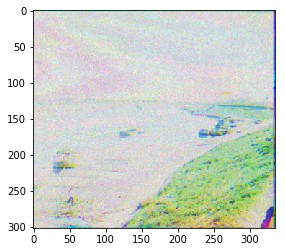

In [10]:
import numpy as np
from skimage import io, transform
from matplotlib import pyplot as plt

channels = io.imread('00029u.png').astype(np.uint8)

def normalize_img(image):
    for i in range(image.shape[2]):
        image[:,:,i]=((image[:,:,i]-(np.min(image[:,:,i])))/((np.max(image[:,:,i]))-(np.min(image[:,:,i]))))
    return image

def getRGBImage(img):
    size1_size=int(round(img.shape[0]/10))
    size2_size=int(round(img.shape[1]/10))
    img = transform.resize(img, ( size1_size,size2_size), anti_aliasing=True).astype('float')
    img_np = np.array(img)
    x1 = 20; y1 = 20;
    x2 = 25; y2 = 333;
    x3 = 24; y3 = 647;
    w = 336; h = 302;
    im1 = img_np[y1-2:y1+h-2,x1-1:x1+w-1];
    im2 = img_np[y2-2:y2+h-2,x2-1:x2+w-1];
    im3 = img_np[y3-2:y3+h-2,x3-1:x3+w-1];
    I1 = im1/np.max(im1)
    I2 = im2/np.max(im2)
    I3 = im3/np.max(im3)
    RGB=np.empty([h,w,3],dtype=float)
    RGB[:,:,0]=I3
    RGB[:,:,1]=I2
    RGB[:,:,2]=I1
    #normalize_img(RGB)
    return RGB

img = getRGBImage(channels)
print(np.max(img), np.min(img))
plt.imshow(img)
plt.show()

(array([2]), array([5]))
[2] [5]
(36, 36)


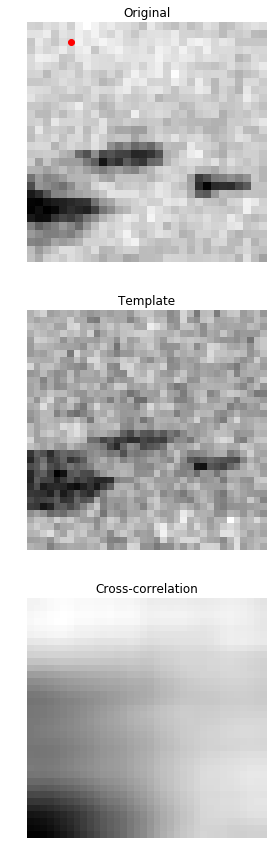

In [9]:
from scipy import ndimage, signal
point=(140,165)    
extents=15
#cropImg = np.empty((extents*2,extents*2,3),dtype=float)   
cropR = img[point[1]-extents:point[1]+extents,point[0]-extents:point[0]+extents,0]
cropG = img[point[1]-18:point[1]+18,point[0]-18:point[0]+18,1]
cropB = img[point[1]-18:point[1]+18,point[0]-18:point[0]+18,2]

corr = signal.correlate2d(cropG, cropR, boundary='symm', mode='same')
shift = np.where(corr==corr.max())
print(shift)
print(shift[0]%cropG[0].shape, shift[1]%cropG[1])
print(corr.shape)
y, x = np.unravel_index(np.argmax(corr), corr.shape)
fig, (ax_orig, ax_template, ax_corr) = plt.subplots(3, 1, figsize=(6, 15))
ax_orig.imshow(cropR, cmap='gray')
ax_orig.set_title('Original')
ax_orig.set_axis_off()
ax_template.imshow(cropG, cmap='gray')
# ax_template.set_title('Template')
# ax_template.set_axis_off()
# ax_corr.imshow(corr, cmap='gray')
# ax_corr.set_title('Cross-correlation')
# ax_corr.set_axis_off()
# ax_orig.plot(x, y, 'ro')
# fig.show()

In [ ]:
def ssd(p1, p2):
    # return the Sum of Squared Differences(SSD)
    p1 = p1.astype(float)
    p2 = p2.astype(float)
    output = (p1/255 - p2/255)**2
    return output.sum()